In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

%matplotlib inline

In [4]:
connection = sqlite3.connect('data/sakila.db')

dvd_df = pd.read_sql('''
    SELECT
        rental.rental_id, rental.rental_date, rental.return_date,
        customer.last_name AS customer_lastname,
        store.store_id,
        city.city AS rental_store_city,
        film.title AS film_title, film.rental_duration AS film_rental_duration,
        film.rental_rate AS film_rental_rate, film.replacement_cost AS film_replacement_cost,
        film.rating AS film_rating
    FROM rental
    INNER JOIN customer ON rental.customer_id == customer.customer_id
    INNER JOIN inventory ON rental.inventory_id == inventory.inventory_id
    INNER JOIN store ON inventory.store_id == store.store_id
    INNER JOIN address ON store.address_id == address.address_id
    INNER JOIN city ON address.city_id == city.city_id
    INNER JOIN film ON inventory.film_id == film.film_id
    ;
''', connection, index_col='rental_id', parse_dates=['rental_date', 'return_date'])

# this is a SQL query that selectes the listed data from the database and joins the different tables from the database on the specified keys.

In [9]:
dvd_df.head()

,rental_date,return_date,customer_lastname,store_id,rental_store_city,film_title,film_rental_duration,film_rental_rate,film_replacement_cost,film_rating
rental_id,,,,,,,,,,
1,2005-05-24 22:53:30,2005-05-26 22:04:30,HUNTER,1,Lethbridge,BLANKET BEVERLY,7,2.99,21.99,G
2,2005-05-24 22:54:33,2005-05-28 19:40:33,COLLAZO,2,Woodridge,FREAKY POCUS,7,2.99,16.99,R
3,2005-05-24 23:03:39,2005-06-01 22:12:39,MURRELL,2,Woodridge,GRADUATE LORD,7,2.99,14.99,G
4,2005-05-24 23:04:41,2005-06-03 01:43:41,PURDY,1,Lethbridge,LOVE SUICIDES,6,0.99,21.99,R
5,2005-05-24 23:05:21,2005-06-02 04:33:21,HANSEN,2,Woodridge,IDOLS SNATCHERS,5,2.99,29.99,NC-17


In [10]:
dvd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16044 entries, 1 to 16049
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   rental_date            16044 non-null  datetime64[ns]
 1   return_date            15861 non-null  datetime64[ns]
 2   customer_lastname      16044 non-null  object        
 3   store_id               16044 non-null  int64         
 4   rental_store_city      16044 non-null  object        
 5   film_title             16044 non-null  object        
 6   film_rental_duration   16044 non-null  int64         
 7   film_rental_rate       16044 non-null  float64       
 8   film_replacement_cost  16044 non-null  float64       
 9   film_rating            16044 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 1.3+ MB


<AxesSubplot: ylabel='Density'>

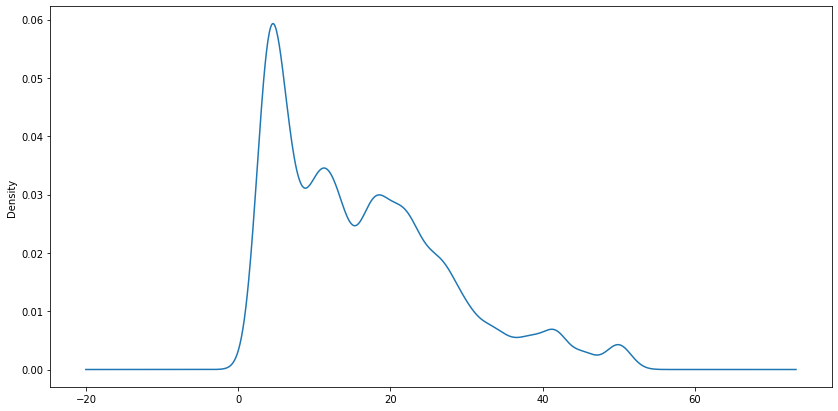

In [12]:
# looking to see the cost of replacing a film in comparison to its rental rate to see films that would be expensive to replace
dvd_df['rental_gain_on_return'] = dvd_df['film_rental_rate'] / dvd_df['film_replacement_cost'] * 100
dvd_df['rental_gain_on_return'].plot(kind='density', figsize=(14,7))

In [13]:
dvd_df.loc[dvd_df['film_replacement_cost'] == dvd_df['film_replacement_cost'].max(), 'film_title'].unique()
# creatomg a list of films with the highest replacement cost to see which ones are most likely to cost a lot if not returned.

array(['IDOLS SNATCHERS', 'LAWLESS VISION', 'SONG HEDWIG',
       'LOATHING LEGALLY', 'PATIENT SISTER', 'RESERVOIR ADAPTATION',
       'JEEPERS WEDDING', 'GOLDFINGER SENSIBILITY', 'CHARIOTS CONSPIRACY',
       'HONEY TIES', 'GRAFFITI LOVE', 'SLACKER LIAISONS', 'DIRTY ACE',
       'BLINDNESS GUN', 'WYOMING STORM', 'FEUD FROGMEN', 'SALUTE APOLLO',
       'JINGLE SAGEBRUSH', 'HILLS NEIGHBORS', 'UNCUT SUICIDES',
       'EVERYONE CRAFT', 'FLATLINERS KILLER', 'BALLROOM MOCKINGBIRD',
       'RIVER OUTLAW', 'ARABIA DOGMA', 'VIRGIN DAISY', 'JERICHO MULAN',
       'SASSY PACKER', 'TRACY CIDER', 'LOVER TRUMAN', 'DOCTOR GRAIL',
       'GILMORE BOILED', 'PRINCESS GIANT', 'CRUELTY UNFORGIVEN',
       'REIGN GENTLEMEN', 'WEST LION', 'BONNIE HOLOCAUST', 'EARTH VISION',
       'RANDOM GO', 'CLOCKWORK PARADISE', 'FANTASIA PARK', 'RIGHT CRANES',
       'CUPBOARD SINNERS', 'OSCAR GOLD', 'SMILE EARRING',
       'HOLLYWOOD ANONYMOUS', 'POSEIDON FOREVER',
       'EXTRAORDINARY CONQUERER', 'QUEST MUSSOLINI', 

In [14]:
dvd_df.loc[dvd_df['film_replacement_cost'] == dvd_df['film_replacement_cost'].max(), 'film_title'].unique().shape[0]
# counting the number of the films that have the highest replacement cost

52

<AxesSubplot: >

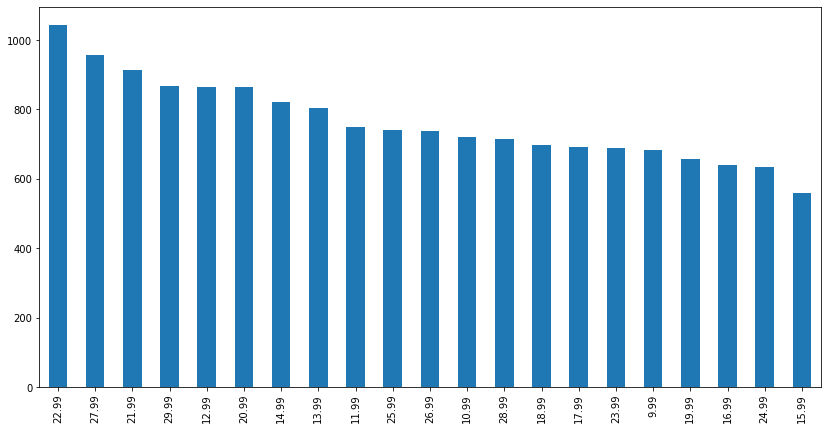

In [16]:
dvd_df['film_replacement_cost'].value_counts().plot(kind='bar', figsize=(14,7))
# showing the count of all of the replacement costs for the films

<AxesSubplot: title={'center': 'film_replacement_cost'}, xlabel='[film_rating]'>

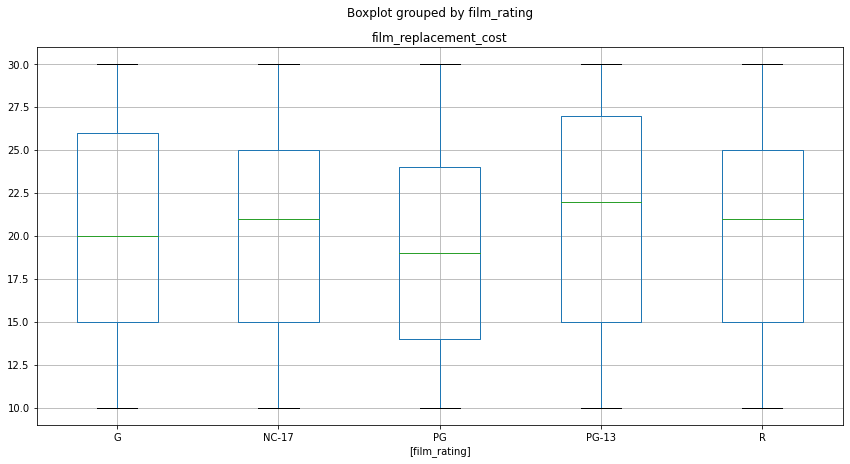

In [18]:
# looking into if the cost of the film could possibly relate to the rating of the film
dvd_df[['film_replacement_cost', 'film_rating']].boxplot(by='film_rating', figsize=(14,7))


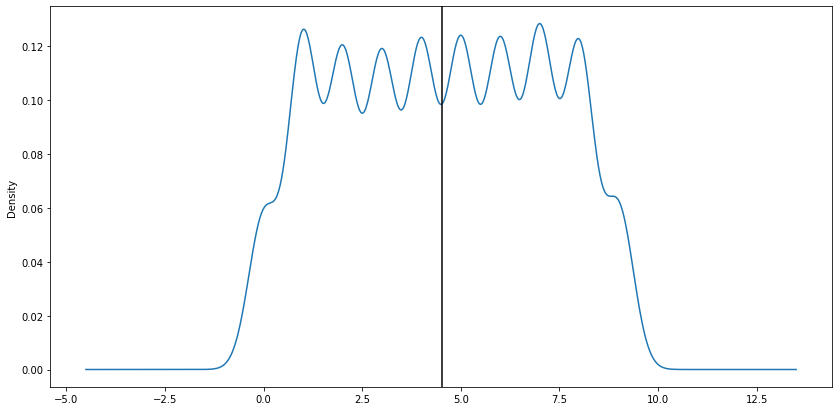

In [20]:
# calculating the number of days films are rented uses a lambda function to subtract the two values.
# the return date is "larger" than the rental date so it must be first in the subtraction 
dvd_df['rental_days'] = dvd_df[['rental_date', 'return_date']].apply(lambda x: (x[1] - x[0]).days, axis=1)

ax = dvd_df['rental_days'].plot(kind='density', figsize=(14,7))
ax.axvline(dvd_df['rental_days'].mean(), color='black')
# creating a density plot for the number of days films are rented, and showing the mean on the plot